## Pytorch basics
- torch.full 
- torch.tensor
- torch.empty

In [7]:
import torch
x=torch.tensor([[1, 2., 3],
                [4, 5, 6],
                [7, 8., 9],
                [10, 11, 12]])
x
x.view(3,-1)
print(x)
z = torch.empty(3,4)
print(z)
z

tensor([[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])


tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [27]:
import torch
class TensorOperation:
    def __init__(self):
        self.a = torch.tensor([1., 2., 3.])
        self.b = torch.tensor([10., 20., 30.])
        self.c= torch. tensor([100., 200., 300.])
    def create_tensor_operation(self):
        self.a.requires_grad=True 
        self.b.requires_grad=True
        a_inter = self.a.pow(2).sum()
        b_inter = self.b.log().sum()
        d =  a_inter + b_inter 
        print(d)
        return d
#print(d.backward())

## autograd
- use of the torch.autograd 
  - it will internally calculate the gradients and calls the .backward method
  - an internal context manager that disables gradient tracking(useful during the evaluation or inference)
- torch.backward
  - computes gradients for the tensors for which requires_grad=True
  - 
- concept of the leaf and non-leaf tensor.


### **1. `requires_grad` and Gradient Storage**
- PyTorch only stores gradients (`.grad`) for tensors that have `requires_grad=True`.
- The scalar `d` (result of `a_inter + b_inter`) **does not require gradients**, because it is not an input tensor but an **intermediate output** derived from operations involving `a` and `b`.

In contrast, `a` and `b` explicitly have `requires_grad=True`, signaling PyTorch to track their contributions to the loss and store their gradients after backpropagation.

---

### **2. What Happens During `d.backward()`**
When you call `d.backward()`:
- PyTorch computes the gradient of `d` (the scalar) **with respect to each input tensor** (`a` and `b`), because these tensors are the ones with `requires_grad=True`.
- The gradients are stored in `a.grad` and `b.grad`, as they are the parameters that PyTorch assumes you will optimize (e.g., in gradient descent).

The scalar `d` itself does not need gradients because:
- It is typically used as a **loss function** or intermediate result.
- There is no meaningful operation involving "gradients of `d` with respect to another scalar."

---

### **3. Why Doesn’t `d` Store `.grad`?**
1. **Scalars Don’t Require Gradients**:
   - Scalars (single values like `d` here) represent the result of an operation, not the starting point for optimization. PyTorch computes the derivatives of scalars with respect to tensors (like `a` and `b`), but it doesn't store `.grad` for scalars themselves.
   - Example:
     ```python
     print(d.grad)  # Will give an error because d is not tracked like a tensor with requires_grad=True
     ```

2. **Intermediate Variables Are Not Retained**:
   - Gradients are only stored for tensors explicitly marked with `requires_grad=True`. Intermediate variables like `d` are ephemeral and do not need `.grad` storage.

3. **Gradient Computation Chain**:
   - Gradients flow **backward** through the computational graph from `d` to `a` and `b`. Since `d` is the end of the graph, its gradient with respect to itself is always \( 1 \), which is trivial and unnecessary to store.

---

### **4. Key Takeaway**
- **Gradients Are Stored in Inputs, Not Outputs**:
  - Gradients flow **back to the inputs (like `a` and `b`)** of the graph because those are the tensors you’re typically optimizing.
  - Intermediate outputs like `d` do not store `.grad` because their role is to propagate gradients, not to be optimized.


In [28]:
tensor = TensorOperation()
d=tensor.create_tensor_operation()
d.backward(retain_graph=True)
#print(d.grad)
print(tensor.a.grad,tensor.b.grad)

tensor(22.6995, grad_fn=<AddBackward0>)
tensor([2., 4., 6.]) tensor([0.1000, 0.0500, 0.0333])


In [ ]:
# let us use the above code for a similar task related to torch.autograd instead of the tensor.backward operation.
tensor1 = TensorOperation()
z = tensor1.create_tensor_operation()
op = torch.autograd.grad(z,[tensor1.a,tensor1.b])
print(op) #results in a tuple first element is the grad wrt a and second elem is grad wrt b.

# what if i have more than 2 , let's say 3 tensors in the input list how the output will come after differentiation

tensor(22.6995, grad_fn=<AddBackward0>)
(tensor([2., 4., 6.], grad_fn=<MulBackward0>), tensor([0.1000, 0.0500, 0.0333], grad_fn=<DivBackward0>))


In [54]:
f = tensor1.a.pow(2).sum() + tensor1.b.log().sum()
g = tensor1.a.pow(2).sum() + tensor1.b.log().sum()
print(torch.autograd.grad([f,g],tensor1.a,retain_graph=True)) 
# the gradients are added from both the results first f and second g.
print(torch.autograd.grad(f,tensor1.a))
print(torch.autograd.grad(g,tensor1.a))

(tensor([ 4.,  8., 12.]),)
(tensor([2., 4., 6.]),)
(tensor([2., 4., 6.]),)


- difference b/w the retain graph and create_graph in pytorch.
- Why Use create_graph=True?
  - By default, PyTorch clears the computational graph after gradients are computed (to save memory). However, higher-order derivatives need the graph to remain intact to compute derivatives of derivatives.
  - create_graph=True ensures that the computational graph for the first derivative is retained.

## Comparison

The difference between `create_graph` and `retain_graph` in PyTorch lies in their roles during gradient computation and the handling of computational graphs. Let’s break it down:

---

### **1. `retain_graph`**
- **Purpose**: It determines whether the computational graph used for backpropagation is retained (kept intact) after gradient computation.
- **Default Behavior**: By default, PyTorch frees the graph after computing gradients to save memory. If you need to compute gradients again using the same graph, you must set `retain_graph=True`.
- **Usage**:
  - Retain the graph to reuse it for further computations:
    ```python
    import torch

    x = torch.tensor(2.0, requires_grad=True)
    y = x**2

    # First backward pass with retain_graph=True
    y.backward(retain_graph=True)
    print(x.grad)  # Output: 4.0

    # Second backward pass (graph retained from the previous pass)
    y.backward()  # Works because the graph was retained
    print(x.grad)  # Output: 8.0 (gradients accumulate by default)
    ```

- **When to Use**:
  - You need to perform multiple backward passes using the same graph (e.g., for gradient penalties or higher-order derivatives).
  
---

### **2. `create_graph`**
- **Purpose**: It enables the creation of a computational graph for higher-order derivatives.
- **Default Behavior**: When computing first-order derivatives, the graph is not created for the gradients themselves. If you need higher-order derivatives, you must set `create_graph=True`.
- **Usage**:
  - Create a graph for higher-order gradient computation:
    ```python
    x = torch.tensor(2.0, requires_grad=True)
    y = x**3

    # Compute the first derivative with create_graph=True
    grad_1 = torch.autograd.grad(y, x, create_graph=True)  # Retain the graph for higher-order gradients
    print(grad_1[0])  # Output: 12.0 (first derivative)

    # Compute the second derivative
    grad_2 = torch.autograd.grad(grad_1[0], x)  # Higher-order gradient computation
    print(grad_2[0])  # Output: 6.0 (second derivative)
    ```

- **When to Use**:
  - You need higher-order derivatives, such as second derivatives or gradient penalties in advanced optimization tasks.

---

### **Key Differences**
| Feature                      | `retain_graph`                     | `create_graph`                     |
|-------------------------------|-------------------------------------|-------------------------------------|
| **Purpose**                  | Retain the graph for reuse         | Enable the creation of a graph for higher-order gradients |
| **Default Behavior**         | Graph is freed after backward      | No graph created for gradients themselves |
| **Use Case**                 | Reusing the graph for multiple backward passes | Computing higher-order derivatives |
| **Impact on Memory**         | Increased memory usage for storing the graph | Additional memory usage for creating gradient graphs |

---

### **Practical Summary**
- Use `retain_graph=True` for reusing the computational graph multiple times within the same session.
- Use `create_graph=True` for higher-order derivatives where gradients themselves need to be differentiated.


In [57]:
# computing the higher order derivatives can be done using the 
x = torch.tensor(10.,requires_grad=True)
y = x**3
result = torch.autograd.grad(y,x,create_graph=True) # results in a tuple
#print(type(result)) # tuple
print(result,x.grad,result[0]) # the .grad doesn't stores information wrt to the autograd in pytorch.
second_result= torch.autograd.grad(result[0],x)
print(second_result,second_result[0])

(tensor(300., grad_fn=<MulBackward0>),) None tensor(300., grad_fn=<MulBackward0>)
(tensor(60.),) tensor(60.)


## Use of the torch.no_grad 

# Gradient Descent Application

# given below function the idea is to apply the gradient descent algorithm 
    - first plot the graph for this function, how can i do that?

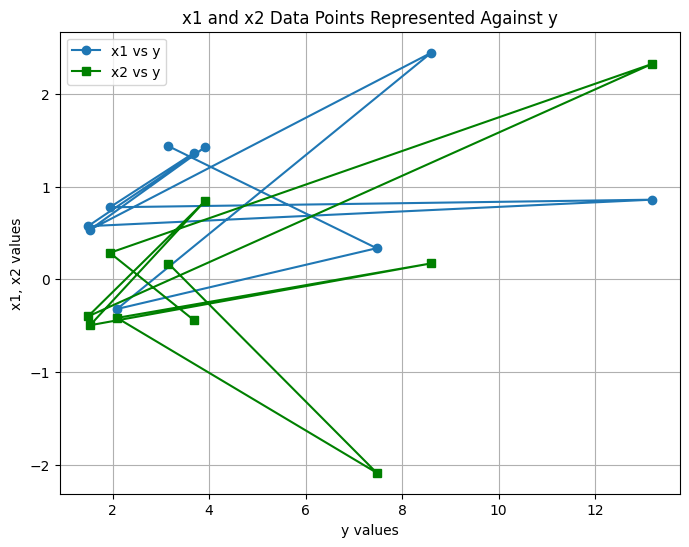

In [72]:
import matplotlib.pyplot as plt
import numpy as np
def f(a, b):
    return (a - 1.0)**2 + (b + 1.)**2 + (a-b)**2

x2_datapoints = []
x1_datapoints = []
y_datapoints = []
for _ in enumerate(range(10)):
    x1 = np.random.randn()
    x2 = np.random.randn()
    y = f(x1,x2)
    x1_datapoints.append(x1)
    x2_datapoints.append(x2)
    y_datapoints.append(y)

plt.figure(figsize=(8, 6))
plt.plot(y_datapoints,x1_datapoints,"o-", label="x1 vs y", )
plt.plot(y_datapoints,x2_datapoints, "s-", label="x2 vs y", color="green")
# results.append((x1,x2,y))

# Add labels and legend
plt.xlabel("y values")
plt.ylabel("x1, x2 values")
plt.title("x1 and x2 Data Points Represented Against y")
plt.legend()
plt.grid()
plt.show()
# plt.plot(results)

## Dual Axis chart

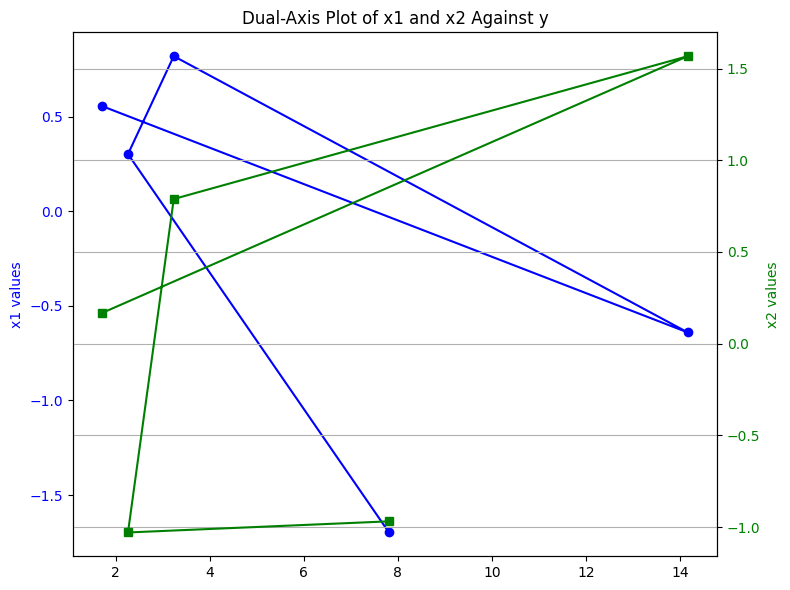

In [70]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# First axis (x1 vs y)
ax1.plot(y_datapoints, x1_datapoints, "o-", label="x1 vs y", color="blue")
ax1.set_ylabel("x1 values", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Second axis (x2 vs y)
ax2 = ax1.twinx()
ax2.plot(y_datapoints, x2_datapoints, "s-", label="x2 vs y", color="green")
ax2.set_ylabel("x2 values", color="green")
ax2.tick_params(axis='y', labelcolor="green")

# Add labels and title
plt.xlabel("y values")
plt.title("Dual-Axis Plot of x1 and x2 Against y")
fig.tight_layout()
plt.grid()
plt.show()


Your code has a subtle but important issue:

## ⚠️ **Issue Explanation:**

In PyTorch, when you perform gradient-based updates manually, you must ensure that the tensors you're updating **do not track gradients during the update step**. Your code attempts to directly modify tensors (`a` and `b`) that have `requires_grad=True` using an in-place operation (`a -= eta*da`). This causes PyTorch to throw an error because it tries to modify a tensor that is part of the computational graph.

Specifically, the line:
```python
a -= eta * da
b -= eta * db
```
attempts in-place operations on tensors that require gradients, which is not allowed.

---

## ✅ **Corrected Version of the Code:**

Here's how you can fix it by using `torch.no_grad()` context and updating tensors safely:

```python
import torch

def gradient_example():
    epoch = 10
    eta = 0.001
    a = torch.tensor(-1.).requires_grad_()
    b = torch.tensor(1.).requires_grad_()

    for k in range(epoch):
        loss = (a - 1.0)**2 + (b + 1.0)**2 + (a - b)**2

        # Compute gradients
        da, db = torch.autograd.grad(loss, (a, b))

        # Update parameters without tracking gradients
        with torch.no_grad():
            a -= eta * da
            b -= eta * db

        # After updating manually, reset gradients explicitly if needed
        a.requires_grad_()
        b.requires_grad_()

        print('iteration %d: loss = %.4f \t a = %.3f \t b = %.3f' % 
              (k, loss.item(), a.item(), b.item()))

gradient_example()
```

---

## ✅ **Why This Fix Works:**

- The `torch.no_grad()` context temporarily disables gradient tracking during parameter updates.
- After updating parameters manually, we re-enable gradient tracking explicitly using `.requires_grad_()`.
- This ensures PyTorch doesn't try to track these manual updates in its computation graph, thus preventing runtime errors.

---

## ✅ **Alternative Solution Using Optimizer:**

A cleaner and recommended approach is to use PyTorch optimizers directly:

```python
import torch

def gradient_example():
    epoch = 10
    eta = 0.001

    # Initialize parameters with requires_grad=True
    a = torch.tensor(-1., requires_grad=True)
    b = torch.tensor(1., requires_grad=True)

    # Use optimizer for updates (e.g., SGD)
    optimizer = torch.optim.SGD([a, b], lr=eta)

    for k in range(epoch):
        optimizer.zero_grad()  # Clear previous gradients

        loss = (a - 1.0)**2 + (b + 1.0)**2 + (a - b)**2

        loss.backward()  # Compute gradients automatically

        optimizer.step()  # Update parameters safely

        print('iteration %d: loss = %.4f \t a = %.3f \t b = %.3f' % 
              (k, loss.item(), a.item(), b.item()))

gradient_example()
```

---

## ✅ **Summary of Key Points:**

| Problem | Solution |
|---------|----------|
| In-place operation on tensors requiring gradients | Use `torch.no_grad()` context or optimizers |
| Manual updates causing computational graph issues | Use `.detach()` or optimizers for safe updates |

By following these corrections and best practices, your code will run correctly and efficiently.


In [87]:
## 
import torch
import numpy as np
def f(a, b):
    return (a - 1.0)**2 + (b + 1.)**2 + (a-b)**2

def gradient_example():
    epoch=  30
    eta=0.01
    a = torch.tensor(1.).requires_grad_()
    b = torch.tensor(-1.).requires_grad_()
    for k in range(epoch):
        loss = (a - 1.0)**2 + (b + 1.0)**2 + (a-b)**2
        da,db=torch.autograd.grad(loss,(a,b))
        with torch.no_grad():
            a -= eta*da
            b -= eta*db
        print('iteration %d: loss = %.4f \t a = %.3f \t b = %.3f, '%(k,loss.item(),a.item(), b.item()))
        print(a.grad,b.grad)


gradient_example()
    

iteration 0: loss = 4.0000 	 a = 0.960 	 b = -0.960, 
None None
iteration 1: loss = 3.6896 	 a = 0.922 	 b = -0.922, 
None None
iteration 2: loss = 3.4153 	 a = 0.887 	 b = -0.887, 
None None
iteration 3: loss = 3.1730 	 a = 0.854 	 b = -0.854, 
None None
iteration 4: loss = 2.9589 	 a = 0.823 	 b = -0.823, 
None None
iteration 5: loss = 2.7696 	 a = 0.793 	 b = -0.793, 
None None
iteration 6: loss = 2.6025 	 a = 0.766 	 b = -0.766, 
None None
iteration 7: loss = 2.4547 	 a = 0.740 	 b = -0.740, 
None None
iteration 8: loss = 2.3242 	 a = 0.715 	 b = -0.715, 
None None
iteration 9: loss = 2.2089 	 a = 0.692 	 b = -0.692, 
None None
iteration 10: loss = 2.1069 	 a = 0.671 	 b = -0.671, 
None None
iteration 11: loss = 2.0169 	 a = 0.651 	 b = -0.651, 
None None
iteration 12: loss = 1.9373 	 a = 0.632 	 b = -0.632, 
None None
iteration 13: loss = 1.8670 	 a = 0.614 	 b = -0.614, 
None None
iteration 14: loss = 1.8049 	 a = 0.597 	 b = -0.597, 
None None
iteration 15: loss = 1.7500 	 a = 0

## 
- always shuffle your data

In [112]:
from torchvision import datasets
import torchvision.transforms as transforms
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data',train=True,download=True,transform=transform)
test_data = datasets.MNIST(root='data',train=False,download=True,transform=transform)

valid_size = 0.2

## shuffle the data before 
len_train = len(train_data)
indices = list(range(len_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * len_train))
train_index, valid_index = indices[split:], indices[:split]

batch_size=50
num_workers=1

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = torch.utils.data.SubsetRandomSampler(valid_index), num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)

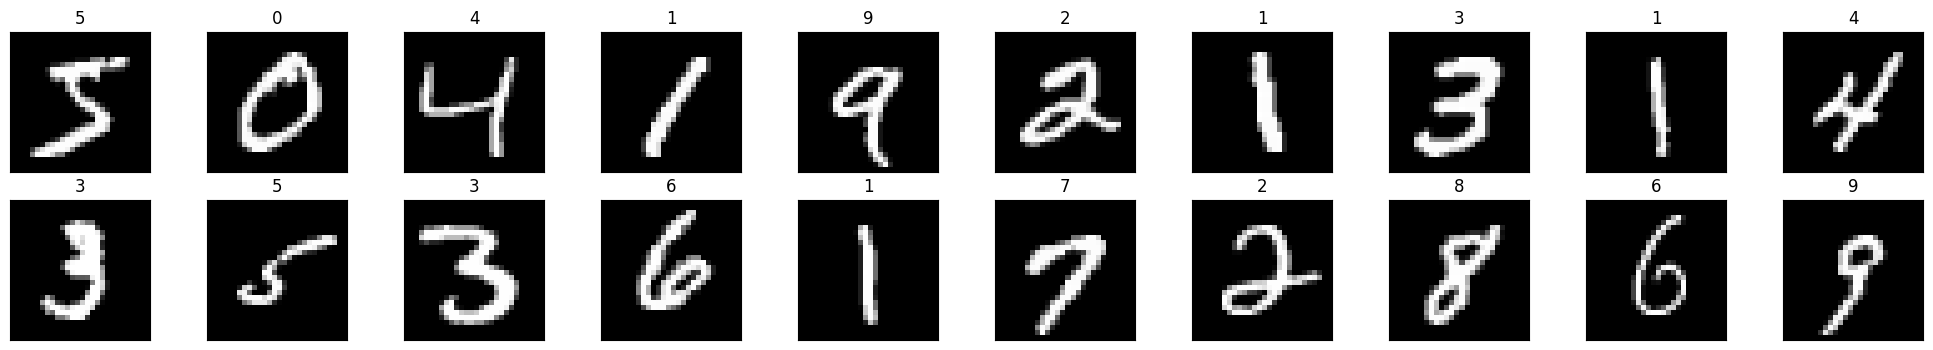

In [113]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
image_np = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [121]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self,img_size,input,hidden,output):
        super().__init__()
        self.fc1 = nn.Linear(img_size,input)
        self.fc2 = nn.Linear(input,hidden)
        self.fc3 = nn.Linear(hidden,output)
    def forward(self,data):
        flattened_data = torch.flatten(data,start_dim=1) 
        #print("input data shape: ",flattened_data.shape) #(50,784)
        flattened_data=torch.relu(self.fc1(flattened_data))
        #print("first layer op shape: ",flattened_data.shape) #(50,128)
        flattened_data=torch.relu(self.fc2(flattened_data))
        #print("second layer op shape: ",flattened_data.shape) #(50,64)
        flattened_data=self.fc3(flattened_data) # why is there no output activation function at the output layer
        #print("third layer op shape: ",flattened_data.shape) #(50,10)
        return flattened_data #(50,10)
    
image_size = 28*28
input = 128
hidden= 64
output=10
mlp = MLP(image_size,input,hidden,output)
# result = mlp.forward(images)
# print(result.shape)
# assert result.shape == (50,10)

## Training and defining the loss function
- training is defined by the gradient descent function
- loss function is cross entropy. why we are going to use the cross entropy, why so?
  - during the training of the model why is there a need for the 

In [124]:

# implement the basic 
cross_entropy_func = nn.CrossEntropyLoss()
n_epochs=10
valid_loss_min = np.Inf
eta=0.01
optimizer = torch.optim.SGD(mlp.parameters(),lr=0.01) # Enable training mode (activates dropout, batch normalization)
# model.train(): enables operations like dropout,batch normalization, etc.
#print(mlp.parameters())
for epoch in range(n_epochs):
    train_loss=0
    valid_loss =0
    mlp.train()
    # why are these 2 codes required?
    #result = mlp.forward(images)
    #images.backward()
    for data,label in train_loader:
        optimizer.zero_grad()
        forward_op=mlp(data)
        loss = cross_entropy_func(forward_op,label)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0) # why this data.size step is required?
    mlp.eval()  
    
    for data,label in valid_loader:
        forward = mlp(data)
        loss_val = cross_entropy_func(forward,label) 
        valid_loss+=loss_val.item()*data.size(0)

    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
        

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        valid_loss
        ))

    # # save model if validation loss has decreased
    # if valid_loss <= valid_loss_min:
    #     print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    #     valid_loss_min,
    #     valid_loss))
    #     torch.save(model.state_dict(), 'model.pt')
    #     valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.191137 	Validation Loss: 0.192085
Epoch: 2 	Training Loss: 0.179029 	Validation Loss: 0.179993
Epoch: 3 	Training Loss: 0.168074 	Validation Loss: 0.169039
Epoch: 4 	Training Loss: 0.158199 	Validation Loss: 0.159179
Epoch: 5 	Training Loss: 0.149289 	Validation Loss: 0.150268
Epoch: 6 	Training Loss: 0.141210 	Validation Loss: 0.142212
Epoch: 7 	Training Loss: 0.133860 	Validation Loss: 0.135048
Epoch: 8 	Training Loss: 0.127081 	Validation Loss: 0.128411
Epoch: 9 	Training Loss: 0.120868 	Validation Loss: 0.122357
Epoch: 10 	Training Loss: 0.115118 	Validation Loss: 0.116872


In [123]:
print(train_loss)

12260.429246583953


## Which gradient descent algo shall we consider
- stochastic gradient descent
- batch gradient descent


Also why is there a need for the train, validation and the test loss separately

2. Validation Loss
Purpose: Validation loss evaluates the model on unseen data (the validation set) after each epoch during training. It acts as a proxy for generalization—the model's ability to perform well on data it hasn't seen during training.

Why It’s Needed:

Prevent Overfitting: A model can overfit the training data, memorizing rather than generalizing patterns. Validation loss ensures the model doesn’t become too specific to the training data.

Hyperparameter Tuning: Use validation loss to select the best model architecture, regularization techniques, learning rate, etc

- do we want to update the parameter in the validation phase? 
  - training loop updates the parameter
  - the validation loop only evaluates the model performance.
  - if the validation loss increases and the training loss decreases what does it indicates? Overfitting
  - if both the loss decreases
- Criteria for the underfitting
  - 

Why is there a need for the StandardScaler